In [22]:
# Spam Email Classifier   

In [23]:
import os
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
import joblib
import nltk

RANDOM_STATE = 42
sns.set(style="whitegrid")

In [24]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chint\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [26]:
data_path = 'spam.csv'

import pandas as pd

df = pd.read_csv(data_path, encoding='latin-1')

if {'v1','v2'}.issubset(df.columns):
    df = df.rename(columns={'v1':'label','v2':'message'})[['label','message']]
elif {'label','message'}.issubset(df.columns):
    df = df[['label','message']]
else:
    df = df.iloc[:, :2]
    df.columns = ['label','message']

print("Dataset shape:", df.shape)
df.head()


Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


label
ham     4825
spam     747
Name: count, dtype: int64


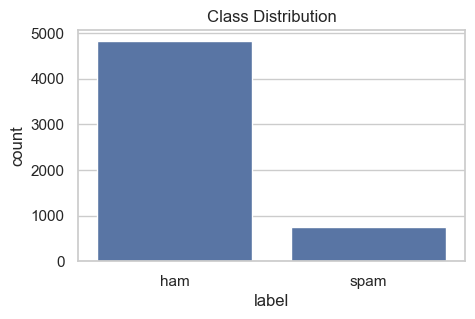

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
print(df['label'].value_counts())
plt.figure(figsize=(5,3))
sns.countplot(x='label', data=df)
plt.title("Class Distribution")
plt.show()



In [28]:
import re, string
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'\S+@\S+', ' ', text)
    text = re.sub(r'http\S+|www\S+', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = text.split()
    tokens = [t for t in tokens if t not in STOPWORDS]
    return ' '.join(tokens)


In [29]:
df['clean'] = df['message'].apply(clean_text)
df[['message','clean','label']].head()


,message,clean,label
0,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis n great ...,ham
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni,ham
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts st ...,spam
3,U dun say so early hor... U c already then say...,u dun say early hor u c already say,ham
4,"Nah I don't think he goes to usf, he lives aro...",nah dont think goes usf lives around though,ham


In [30]:
from sklearn.model_selection import train_test_split

df['label_num'] = df['label'].map({'ham':0, 'spam':1})
X = df['clean']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])


Train size: 4457 Test size: 1115


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=4000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000))
])

pipeline_lr.fit(X_train, y_train)
preds_lr = pipeline_lr.predict(X_test)

print("Accuracy:", accuracy_score(y_test, preds_lr))
print(classification_report(y_test, preds_lr))



Accuracy: 0.967713004484305
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       966
           1       0.97      0.78      0.87       149

    accuracy                           0.97      1115
   macro avg       0.97      0.89      0.92      1115
weighted avg       0.97      0.97      0.97      1115



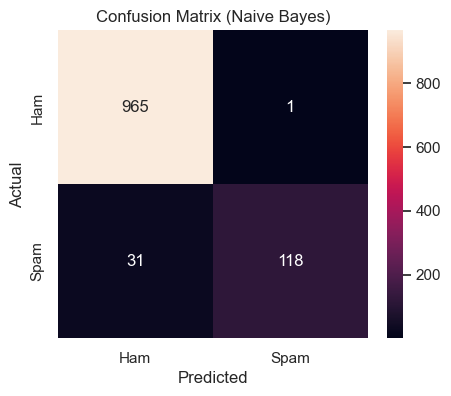

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, preds_nb)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=['Ham','Spam'], yticklabels=['Ham','Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Naive Bayes)')
plt.show()


In [50]:
import joblib
joblib.dump(pipeline_lr, 'spam_pipeline.joblib')
print("Model saved successfully!")


Model saved successfully!


In [34]:
loaded_model = joblib.load('spam_pipeline.joblib')

examples = [
    "Congratulations! You’ve won a free iPhone! Call now!",
    "Hey, are we still meeting for lunch tomorrow?",
    "Your Netflix account has been suspended, click here to update details."
]

for msg in examples:
    pred = loaded_model.predict([msg])[0]
    label = "SPAM" if pred == 1 else "NOT SPAM"
    print(f"Message: {msg}\n → Prediction: {label}\n")


Message: Congratulations! You’ve won a free iPhone! Call now!
 → Prediction: SPAM

Message: Hey, are we still meeting for lunch tomorrow?
 → Prediction: NOT SPAM

Message: Your Netflix account has been suspended, click here to update details.
 → Prediction: NOT SPAM



In [35]:
import pandas as pd
from sklearn.metrics import confusion_matrix

y_pred = loaded_model.predict(X_test)
errors = pd.DataFrame({
    'message': X_test,
    'actual': y_test,
    'predicted': y_pred
})
errors = errors[errors['actual'] != errors['predicted']]
errors.to_csv('model_errors.csv', index=False)
print(f"Saved {len(errors)} misclassified messages to model_errors.csv")


Saved 32 misclassified messages to model_errors.csv


In [37]:
import joblib

model = joblib.load('spam_pipeline.joblib')
msg = "You have won $1000! Click here!"
print(model.predict([msg])[0])
print(model.predict_proba([msg])[0])


0
[0.68245847 0.31754153]


In [51]:
import os
print("Current working directory:", os.getcwd())
print("Files here:", os.listdir())


Current working directory: c:\Users\chint\OneDrive\Desktop\SpamEmailClassifier
Files here: ['app.py', 'model_errors.csv', 'spam.csv', 'spam_pipeline.joblib', 'words.ipynb']


In [52]:
import os, joblib

save_path = os.path.join(os.getcwd(), "spam_pipeline.joblib")
print("Saving to:", save_path)
joblib.dump(pipeline_lr, save_path)


Saving to: c:\Users\chint\OneDrive\Desktop\SpamEmailClassifier\spam_pipeline.joblib


['c:\\Users\\chint\\OneDrive\\Desktop\\SpamEmailClassifier\\spam_pipeline.joblib']

In [53]:
model = joblib.load(save_path)
msg = "You have won $1000! Click here!"
print(model.predict([msg])[0])
print(model.predict_proba([msg])[0])


0
[0.87858103 0.12141897]


In [55]:
msg = "You have won $1000! Click here!"
proba = model.predict_proba([msg])[0][1]
label = "SPAM" if proba > 0.1 else "NOT SPAM"

print(label, f"(Spam probability: {proba*100:.2f}%)")


SPAM (Spam probability: 12.14%)
